In [1]:
import pandas as pd
import numpy as np
import xarray
from pyeosim.spectral import TreeView_3
import seaborn
import matplotlib.pyplot as plt

In [8]:
class SREM_atmospheric_correction(object):
    """
    Implements the Simplified Robust Estimation Method
    
    Methods
    -------
    transform(signal)
        converts at-sensor radiance to estimated BOA reflectance
    """
    def __init__(self, solar_z, solar_a, view_z, view_a,
                 day_of_year, spectral_response,
                 solar_spectrum='solar_irradiance/e490_00a_amo.xls'):
        """
        Parameters
        ----------
        solar_z : float
            solar zenith in deg
        solar_a : float
            solar angle in deg
        view_z : float
            view zenith in deg
        view_a : float
            view angle in deg
        day_of_year : int
            day of Julian calendar
        spectral_response : SRF
            spectral response object from pyeosim.spectral
        solar_spectrum : str or xarray.DataArray, optional
            path to E490 solar extraterrestrial spectrum (default) or
            DataArray with irradiance in W m-2 nm-1 and wavelength
            in nm
        """
        self.solar_z = solar_z
        self.solar_a = solar_a
        self.view_z = view_z
        self.view_a = view_a
        self.doy = day_of_year
        self.spectral_response = spectral_response
        # either load or use directly
        if type(solar_spectrum) == str:
            self.solar_spectrum = self._load_solar_E(solar_spectrum)
        else:
            self.solar_spectrum = solar_spectrum
        self._generate_params()

    def _load_solar_E(self, fpath):
        f = pd.read_excel(fpath)
        # convert micron to nm
        wlen = f.iloc[:, 0].values * 1000
        # convert W m2 micron to W m2 nm
        E_wm2 = f.iloc[:, 1].values / 1000
        return xarray.DataArray(
            E_wm2,
            coords={'wavelength': wlen}).sel(wavelength=slice(280, 3000, 1))
        
    def _rho_s(self, rho_toa, rho_r, S_atm, T_s, T_v):
        return (rho_toa - rho_r) / (S_atm * (rho_toa - rho_r) + (T_s * T_v))

    def _mu_s(self, solar_z):
        return np.cos(np.deg2rad(solar_z))

    def _mu_v(self, view_z):
        return np.cos(np.deg2rad(view_z))

    def _d(self, day_of_year):
        # solar distance in AUs
        C0 = 0.03275104
        C1 = 59.66638337
        C2 = 0.96804905
        return C0 * np.cos(day_of_year / C1) + C2
    
    def _E_sun(self, spectral_response, solar_spectrum):
        return spectral_response.transform(solar_spectrum)
    
    def _rho_toa(self, L, d, mu_s, E_sun):
        # generate per- band E_sun
        return (np.pi * L * d**2) / (E_sun * mu_s)

    def _rho_r(self, P_r, M, mu_s, mu_v, tau_r):
        return P_r * ((1-np.exp(-M * tau_r)) / (4 * (mu_s + mu_v)))

    def _M(self, mu_s, mu_v):
        return (1/mu_s) + (1/mu_v)

    def _tau_r(self, spectral_response):
        C0 = 0.008569
        C1 = 0.0113
        C2 = 0.0013
        tau_r = []
        for wlen in spectral_response.band_wavelengths.values():
            # keep as nm for now but might need to be changed to m
            lam = wlen
            tau_r.append(C0 * (lam**-4) * (1+ (C1 * (lam ** -2)) + (C2 * (lam ** -1))))
        return xarray.DataArray(tau_r, coords={'band':np.arange(len(tau_r))})

    def _P_r(self, Theta):
        A = 0.9587256
        B = 1 - A
        return ((3 * A) / 4 + B) * (1+(np.cos(np.deg2rad(Theta)) **2))

    def _S_atm(self, tau_r):
        return (0.92 * tau_r) * np.exp(-tau_r)

    def _T_s(self, mu_s, tau_r):
        return np.exp((-tau_r) / mu_s) + (np.exp((-tau_r) / mu_s) * (np.exp((0.52 * tau_r) / mu_s) -1))

    def _T_v(self, mu_v, tau_r):
        return np.exp((-tau_r) / mu_v) + (np.exp((-tau_r) / mu_v) * (np.exp((0.52 * tau_r) / mu_v) -1))
    
    def _scattering_angle(self, solar_a, view_a, mu_s, mu_v):
        phi = np.abs(view_a - solar_a)
        phi_rad = np.deg2rad(phi)
        if phi_rad < 0:
            phi_rad = phi_rad + (2 * np.pi)
        elif phi_rad > (2 * np.pi):
            phi_rad = phi_rad - (2 * np.pi)
        mu_p = np.cos(phi_rad)
        mu_d = -mu_s * mu_v - np.sqrt(1 - mu_s**2) * np.sqrt(1 - mu_v **2) * mu_p
        theta_dif = np.rad2deg(np.arccos(mu_d))
        return theta_dif

    def _generate_params(self):

        self.mu_s = self._mu_s(self.solar_z)
        self.mu_v = self._mu_v(self.view_z)
        self.scattering_angle = self._scattering_angle(self.solar_z, self.view_z, self.mu_s, self.mu_v)
        self.d = self._d(self.doy)
        self.M = self._M(self.mu_s, self.mu_v)
        self.tau_r = self._tau_r(self.spectral_response)
        self.P_r = self._P_r(self.scattering_angle)
        self.E_sun = self._E_sun(self.spectral_response, self.solar_spectrum)
        self.S_atm = self._S_atm(self.tau_r)
        self.T_s = self._T_s(self.mu_s, self.tau_r)
        self.T_v = self._T_v(self.mu_v, self.tau_r)
        self.rho_r = self._rho_r(self.P_r, self.M, self.mu_s, self.mu_v, self.tau_r)
        
    def transform(self, L):
        self.rho_toa = self._rho_toa(L, self.d, self.mu_s, self.E_sun)
        return self._rho_s(self.rho_toa, self.rho_r, self.S_atm, self.T_s, self.T_v)

In [9]:
tv3 = TreeView_3()
radiance = xarray.load_dataarray('sensor_radiance.nc')
s = SREM_atmospheric_correction(33, 140, 0, 0, 173, tv3)
corrected = s.transform(radiance)

In [10]:
tv_large = xarray.load_dataarray('medium_treeview_test_data.nc')

In [11]:
radiance_large

<xarray.DataArray (band: 8, y: 1238, x: 1238)>
array([[[ 786,  807,  787, ...,  727,  725,  716],
        [ 784,  796,  808, ...,  722,  720,  732],
        [ 791,  801,  830, ...,  736,  761,  763],
        ...,
        [ 862,  903, 1293, ...,  734,  727,  737],
        [ 848,  858,  911, ...,  735,  733,  740],
        [ 861,  854,  861, ...,  726,  742,  742]],

       [[2373, 2415, 2301, ..., 1892, 1878, 1894],
        [2297, 2415, 2487, ..., 1897, 1918, 1910],
        [2332, 2447, 2567, ..., 1906, 2006, 2019],
        ...,
        [2174, 2354, 4065, ..., 1855, 1775, 1893],
        [2172, 2159, 2363, ..., 1924, 1861, 1864],
        [2247, 2190, 2216, ..., 1828, 1884, 1848]],

       [[3000, 3076, 2880, ..., 1979, 1972, 1985],
        [2851, 3046, 3207, ..., 2029, 2061, 2076],
        [2951, 3117, 3334, ..., 2051, 2306, 2326],
        ...,
...
        ...,
        [ 709,  758, 1500, ...,  961,  874,  975],
        [ 721,  691,  773, ...,  981,  891,  950],
        [ 754,  731,  713, ...,  986,  929,  984]],

       [[ 945,  922,  915, ..., 1780, 1629, 1623],
        [ 912,  928,  955, ..., 1681, 1541, 1511],
        [ 929,  934,  963, ..., 1338,  810,  813],
        ...,
        [ 544,  578, 1111, ...,  823,  753,  827],
        [ 549,  533,  580, ...,  839,  756,  815],
        [ 585,  565,  543, ...,  849,  801,  845]],

       [[1170, 1154, 1157, ..., 2331, 2132, 2143],
        [1147, 1162, 1185, ..., 2153, 2008, 1952],
        [1154, 1164, 1202, ..., 1705, 1030, 1024],
        ...,
        [ 606,  644, 1155, ..., 1054,  979, 1077],
        [ 622,  606,  646, ..., 1082,  992, 1049],
        [ 648,  630,  601, ..., 1102, 1047, 1105]]], dtype=uint16)
Coordinates:
  * band        (band) int64 0 1 2 3 4 5 6 7
    band_name   (band) object 'Aerosol' 'PRI_1' 'PRI_2' ... 'RedEdge_3' 'NIR'
    wavelength  (band) int64 440 525 585 630 670 740 780 865
  * x           (x) float64 6.517e+05 6.517e+05 ... 6.542e+05 6.542e+05
  * y           (y) float64 5.763e+06 5.763e+06 ... 5.765e+06 5.765e+06
Attributes:
    TdiCmos_sensor_simulation:  {"_fitted": true, "sensor_altitude": 500000.0...

In [5]:
corrected2 = s.transform(radiance_large)

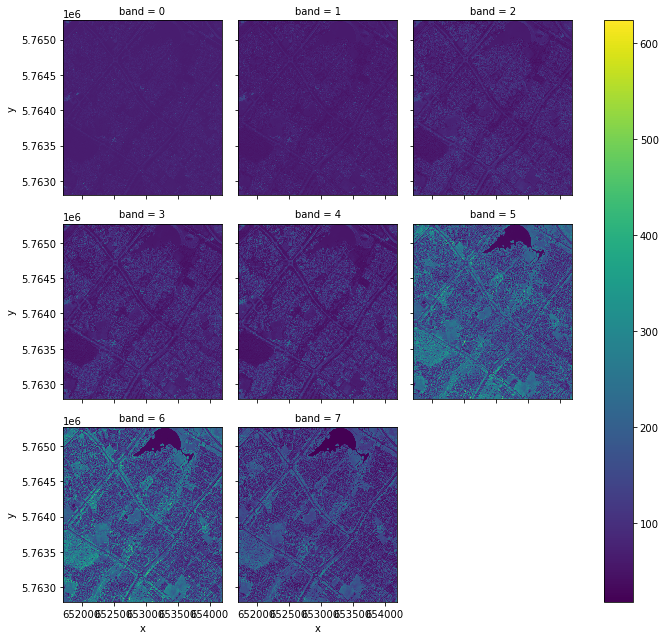

In [6]:
corrected2.plot(col='band', col_wrap=3)

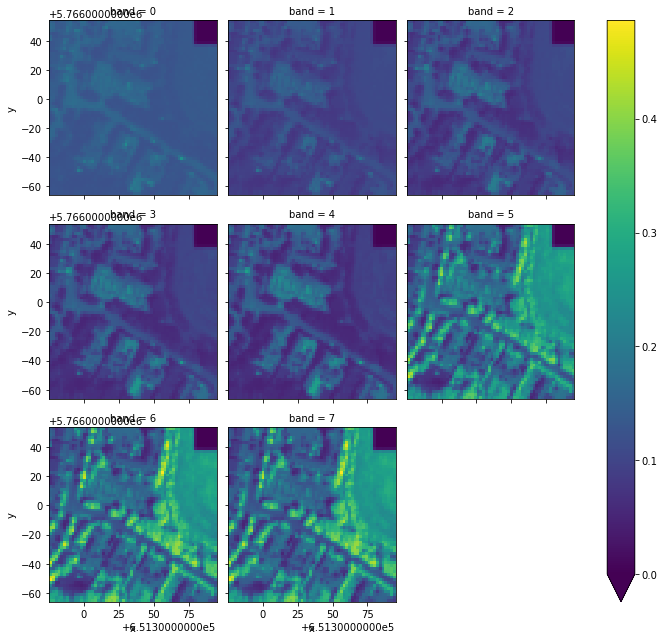

In [76]:
truth = xarray.load_dataarray('sensor_equiv_reflectance.nc')
dark_region_mask = xarray.zeros_like(truth.isel(band=0)).astype(bool)
dark_region_mask[50:60, 50:60] = 1

bw = xarray.DataArray(
    [20, 50, 50, 40, 40, 14, 14, 30],
    coords={'band': np.arange(8)}
)

# corrected = correct(radiance, tv3, 33, 140, 146.7, 173,  load_solar_E())
corrected.plot(col='band', vmin=0, col_wrap=3, size=3)

(0.0, 0.6)

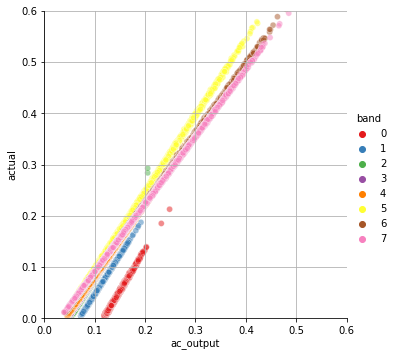

In [77]:
obs = corrected.where(~dark_region_mask)
obs_df = obs.stack({'pix': ['y', 'x']}).to_dataframe(name='ac_output')

exp = truth.where(~dark_region_mask)
exp_df = exp.stack({'pix': ['y', 'x']}).to_dataframe(name='expected')

obs_df['actual'] = exp_df['expected']
seaborn.relplot(data=obs_df,
                x='ac_output',
                y='actual',
                hue='band',
                palette='Set1',
                alpha=.5)
plt.grid()
plt.xlim(0,.6)
plt.ylim(0,.6)

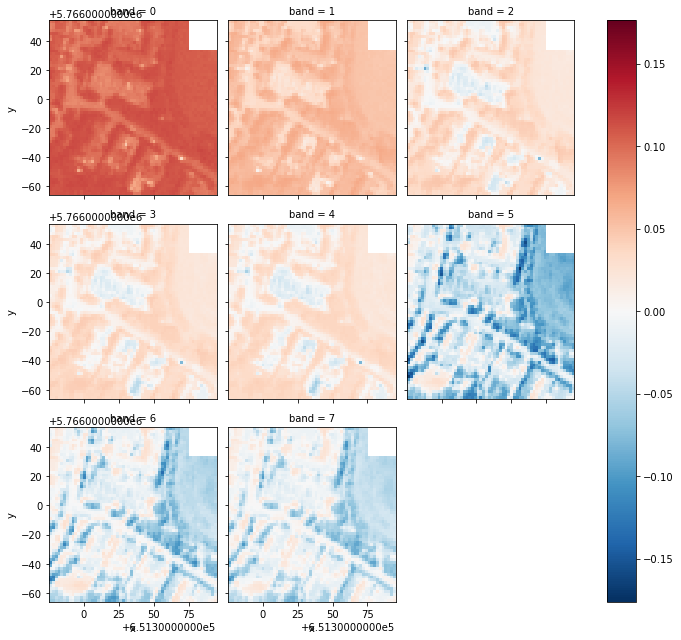

In [78]:
(obs - truth).plot(col='band', col_wrap=3)